# Exogenous data for ``message_ix_models`` & co.

In [1]:
from genno import Computer
from message_ix_models import Context

<IPython.core.display.Javascript object>

We want to set up this Computer instance with a ready-made key that will return us population, GDP, or other exogenous data, for use in various other model-building calculations:

In [2]:
c = Computer()
c, c.keys()

(<genno.core.computer.Computer at 0x7fabe1895390>, dict_keys(['config']))

For this, we use a function named [`prepare_computer`](https://docs.messageix.org/projects/models/en/latest/api/tools.html#message_ix_models.tools.exo_data.prepare_computer) (a link, click):

In [3]:
from message_ix_models.tools.exo_data import prepare_computer

# Show the signature and docstring
help(prepare_computer)

Help on function prepare_computer in module message_ix_models.tools.exo_data:

prepare_computer(context, c: 'Computer', source='test', source_kw: Optional[Mapping] = None, *, strict: bool = True) -> Tuple[genno.core.key.Key, ...]
    Prepare `c` to compute GDP, population, or other exogenous data.
    
    Check each :class:`ExoDataSource` in :data:`SOURCES` to determine whether it
    recognizes and can handle `source` and `source_kw`. If a source is identified, add
    tasks to `c` that retrieve and process data into a :class:`.Quantity` with, at
    least, dimensions :math:`(n, y)`.
    
    Parameters
    ----------
    source : str
        Identifier of the source, possibly with other information to be handled by a
        :class:`ExoDataSource`.
    source_kw : dict, *optional*
        Keyword arguments for a Source class. These can include indexers, selectors, or
        other information needed by the source class to identify the data to be
        returned.
    
        If the

This function “dispatches” to or identifies one subclass (among many) of ExoDataSource. Each class knows how to retrieve/prepare data for one source—hence the name.

In [4]:
# Individual data source classes must be imported to be usable
# This might be relaxed in a future version—what do you think?
from message_ix_models.project.ssp.data import SSPOriginal, SSPUpdate

For this, we use the enumerations/code lists previously shown to distinguish the SSPs from the different sets:

In [5]:
from message_ix_models.project.ssp import SSP_2017, SSP_2024

print(SSP_2017["2"])
print(SSP_2024["2"])

ICONICS:SSP(2017).2
ICONICS:SSP(2024).2


As seen above `prepare_computer()` takes two arguments *source* and *source_kw*.

Each ExoDataSource subclass gets a chance to look at these and say "Yes, I know what these mean and can provide this data," or "No, I can't".

In [6]:
source = str(SSP_2024["2"])
source_kw = dict(measure="POP", model="OECD Env-Growth")

There are essentially no requirements on what these must be: they are flexible and extensible. For instance
  - `source="ICONICS:SSP(2024).2"` identifies both a particular source *and* query parameters for that source.
    This is what we think of as "SSP2", although the particular code that apears in the actual data is different, so like "SSP2v9_130325".
    The class takes care of this detail, so you don't need to worry about it when using it.
  - "measure" in *solve_kw*: the thing measured.
  - "model", "scenario" in *solve_kw*: these are relevant if the incoming data is in IAMC structure/format.
     But a particular ExoDataSource can draw from *any* data format or source, including with those with more or fewer dimensions.

We also need a Context instance.
The code respects the `regions` setting:

In [7]:
ctx = Context()
ctx.model.regions

'R14'

(R14 is the default.)

Now actually call the function:

In [8]:
prepare_computer(ctx, c, source, source_kw)

(<pop:n-y>, <pop:n-y:y0_indexed>)

The function returns some genno Keys that were added and that you would likely want to use in further computations.

We can use the built-in `describe()` and `visualize()` methods to see what these would do:

'pop:n-y:y0_indexed':
- index_to
- 'pop:n-y':
  - 'pop:n-y:SSP update+2':
    - interpolate(kwargs={'fill_value': 'extrapolate'}, ...)
    - 'pop:n-y:SSP update+1':
      - aggregate(keep=False, ...)
      - 'pop:n-y:SSP update':
        - <message_ix_models.project.ssp.data.SSPUpdate object at 0x7fabdf841890>
      - 'n::groups':
        - codelist_to_groups
        - 'n::codes':
          - [<Code AFI: French Afars and Issas>, <Code ANT: Netherlands Antilles>, <Code ATB: British Antarctic Territory>, <Code BUR: Burma, Socialist Republic of [...]
    - 'y::coords':
      - <lambda>
      - 'y':
        - [2020, 2025, 2030, 2035, 2040, 2045, 2050, 2055, 2060, 2070, 2080, 2090, 2100, 2110]
- 'y0::coord':
  - <lambda>
  - 'y0':
    - operator.itemgetter(0)
    - 'y' (above)


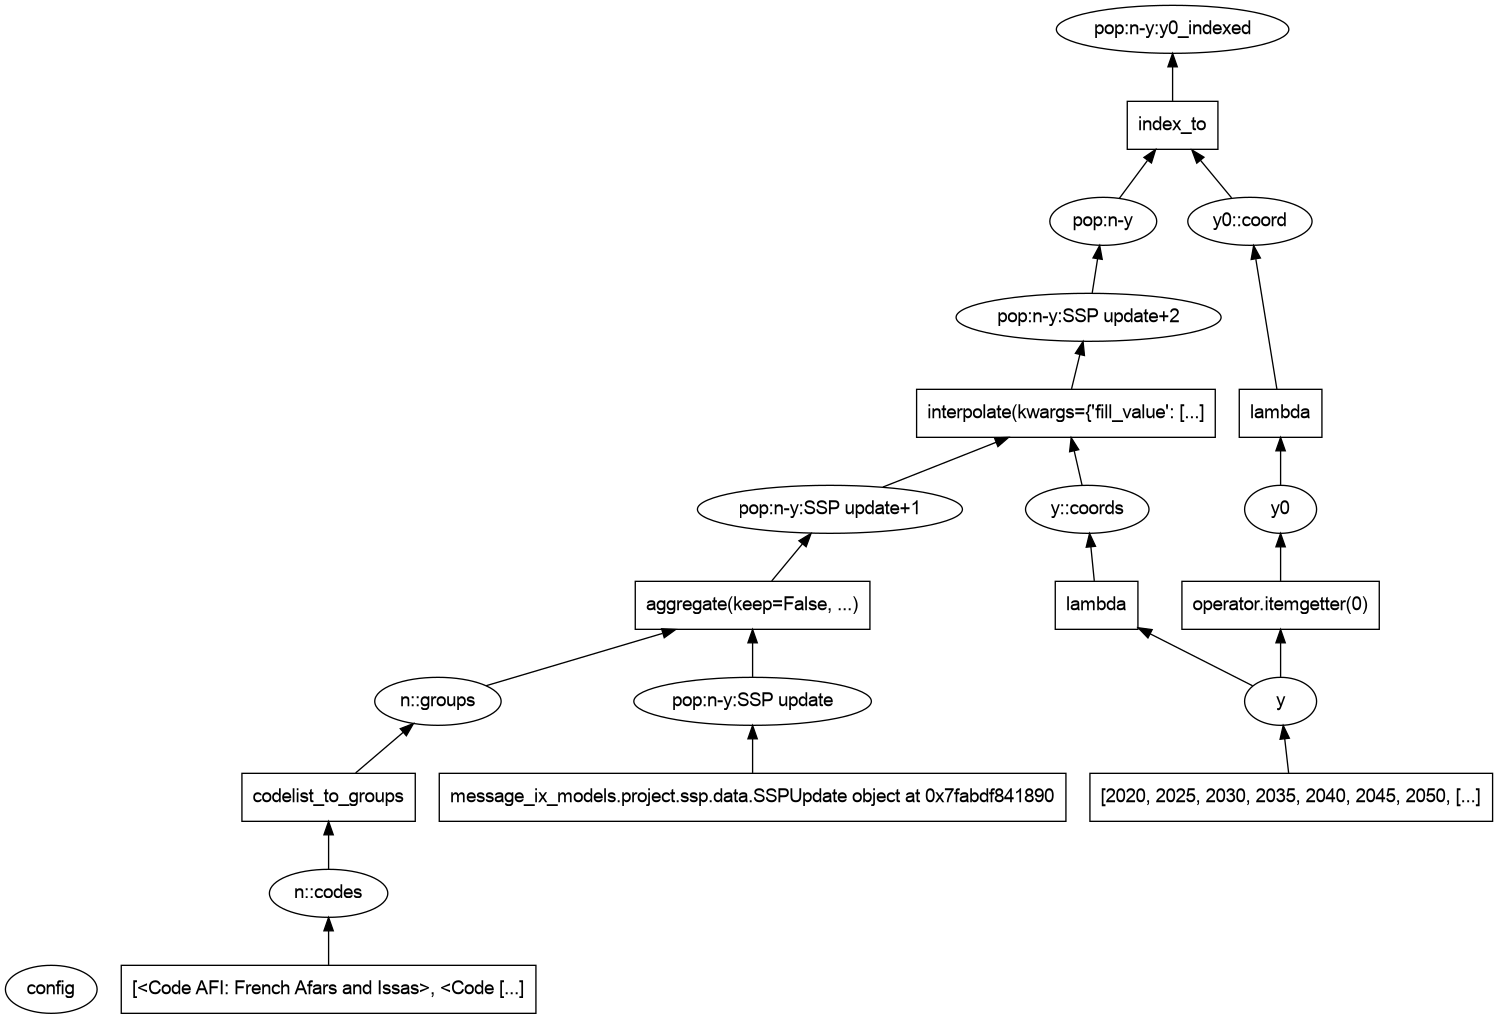

In [9]:
print(c.describe("pop:n-y:y0_indexed"))
c.visualize("pop:n-y:y0_indexed")

Now let's try to actually execute these tasks:

In [10]:
c.get("pop:n-y")

ComputationError: computing <pop:n-y:SSP update> using:

(<message_ix_models.project.ssp.data.SSPUpdate object at 0x7fabdf841890>,)

Use Computer.describe(...) to trace the computation.

Computation traceback:
  File "/home/khaeru/vc/iiasa/models/message_ix_models/project/ssp/data.py", line 175, in __call__
    return iamc_like_data_for_query(path, query)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/khaeru/vc/genno/genno/caching.py", line 205, in cached_load
    data = func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/home/khaeru/vc/iiasa/models/message_ix_models/tools/exo_data.py", line 357, in iamc_like_data_for_query
    .pipe(drop_unique, "MODEL SCENARIO VARIABLE UNIT")
     ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/khaeru/.venv/3.11/lib/python3.11/site-packages/pandas/core/generic.py", line 5926, in pipe
    return common.pipe(self, func, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/khaeru/.venv/3.11/lib/python3.11/site-packages/pandas/core/common.py", line 518, in pipe
    return func(obj, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/khaeru/vc/iiasa/models/message_ix_models/tools/exo_data.py", line 325, in drop_unique
    raise RuntimeError(f"0 rows matching {query!r}")
RuntimeError: 0 rows matching "Scenario == 'SSP2 - Review Phase 1' and Variable == 'Population' and Model == 'OECD Env-Growth'"


In this case, we didn't provide a working combination of *source_kw*.
The class provides an error message that can direct us back to our docs to correct the error.
(It could also do this earlier, by raising an exception when we tried to `prepare_computer()`.)

In this case, the "model" codes differ between the SSPOriginal and SSPUpdate sources. Let's use one that actually appears in the data:

In [11]:
source_kw = dict(measure="POP", model="IIASA-WiC POP 2023")

c = Computer()

prepare_computer(ctx, c, source, source_kw)

(<pop:n-y>, <pop:n-y:y0_indexed>)

In [12]:
c.get("pop:n-y")

n        y   
R14_AFR  2020    1009.367834
         2025    1140.516252
         2030    1280.138879
         2035    1425.193519
         2040    1573.428303
                    ...     
R14_WEU  2070     529.438030
         2080     525.731016
         2090     519.556543
         2100     510.137638
         2110     499.895214
Length: 196, dtype: float64, units: million

In [ ]:
c.get("pop:n-y:y0_indexed")

## How it works

[`ExoDataSource` class docs](https://docs.messageix.org/projects/models/en/latest/api/tools.html#message_ix_models.tools.exo_data.ExoDataSource) and source:
- `__init__()` method: inspect/handle *source*, *source_kw* and either (a) prepare to retrieve the data or (b) raise `ValueError` ("This class can't handle these arguments; please try another one.")
- `__call__()` method: actually perform the (possibly slow) steps of reading the data from its "raw" or "native" format; selecting; transforming to genno.Quantity.
- Other attributes and features:
  - `extra_dims`: the source can return additional dimensions beyond $n, y$
  - `name` (also an optional key in *source_kw*): change the names of keys added to the Computer; can produce "foo:n-y" instead of "pop:n-y"
  - `transform`: override the default transformation steps of (aggregate on $n$, interpolate on $y$).
 
## Learn/do more
- Write additional ExoDataSource classes.
- Chain into other `genno` calculations and operators.
  - Multiply by scaling factors.
  - Convert units.
- Use in both model-building (pre-solve) and reporting.
  These codes can be **agnostic about the source of data**; they simply need to know that a key "pop:n-y" (or similar) exists which will return population data in an expected format.
  Thus:
  - Easy to support *any* exogenous source for a particular measure.